# Is there a correlation between font choice and college ranking?
### An frivilous exploration started on a whim 
#### By: Tony Zheng

## Ranking Data & URLs
This exploration is done using the US News university rankings for 2024, collected using a slightly modified version of <a href="https://github.com/kajchang/">kajchang</a>'s <a href="https://github.com/kajchang/USNews-College-Scraper">scraper</a> to collect university website URLs and ranks (outputted to <a href="Scraper/data-detailed.csv">a csv</a>).

First, we'll get the US News rankings and collect them.

In [125]:
import Scraper

from Scraper.main import main as scrape
# each page has 10 schools in it
scrape(n_pages = 30)

Fetching https://www.usnews.com/best-colleges/api/search?_sort=rank&_sortDirection=asc&_page=1...
Fetching https://www.usnews.com/best-colleges/api/search?_sort=rank&_sortDirection=asc&_page=2...
Fetching https://www.usnews.com/best-colleges/api/search?_sort=rank&_sortDirection=asc&_page=3...
Fetching https://www.usnews.com/best-colleges/api/search?_sort=rank&_sortDirection=asc&_page=4...
Fetching https://www.usnews.com/best-colleges/api/search?_sort=rank&_sortDirection=asc&_page=5...
Fetching https://www.usnews.com/best-colleges/api/search?_sort=rank&_sortDirection=asc&_page=6...
Fetching https://www.usnews.com/best-colleges/api/search?_sort=rank&_sortDirection=asc&_page=7...
Fetching https://www.usnews.com/best-colleges/api/search?_sort=rank&_sortDirection=asc&_page=8...
Fetching https://www.usnews.com/best-colleges/api/search?_sort=rank&_sortDirection=asc&_page=9...
Fetching https://www.usnews.com/best-colleges/api/search?_sort=rank&_sortDirection=asc&_page=10...
Fetching https://ww

Let's read that in...

In [126]:
import pandas as pd

data = pd.read_csv("Scraper/data-detailed.csv")
data

,institution.displayName,ranking.sortRank,ranking.isTied,Visit School Website
0,Princeton University,1,False,http://www.princeton.edu
1,Massachusetts Institute of Technology,2,False,http://web.mit.edu/
2,Harvard University,3,True,http://www.harvard.edu/
3,Stanford University,3,True,http://www.stanford.edu
4,Yale University,5,False,http://www.yale.edu/
...,...,...,...,...
295,Alvernia University,296,True,https://www.alvernia.edu/
296,Edgewood College,296,True,http://www.edgewood.edu
297,New Mexico State University,296,True,http://www.nmsu.edu
298,Saint Mary's University of Minnesota,296,True,https://www.smumn.edu/admission


... and make sure that nothing is missing

In [127]:
data.isna().sum()

institution.displayName    0
ranking.sortRank           0
ranking.isTied             0
Visit School Website       0
dtype: int64

## Filtering text and getting fonts

Now, we'll use selenium to request a school's website and get the "font-family" fields of every text field

In [128]:
from selenium import webdriver

def ExtractAlphanumeric(InputString):
    from string import ascii_letters, digits
    return "".join([ch for ch in InputString if ch in (ascii_letters + digits)])

def get_fonts(url):
    """Return a list of tuples containing (font-family, text length) pairs."""
    options = webdriver.FirefoxOptions()
    options.add_argument('-headless')
    driver = webdriver.Firefox(executable_path="Scraper/geckodriver.exe", options=options)
    driver.get(url)

    # Finds elements that are text fields
    elements = driver.find_elements_by_xpath("//*[text()]")
    
    fonts = []
    for element in elements:
        element_fonts = element.value_of_css_property("font-family")\
            .split(",")
        
        for i in range(len(element_fonts)): element_fonts[i] = ExtractAlphanumeric(element_fonts[i])
        
        fonts.append((element_fonts, len(element.text)))
    
    driver.quit()
    return fonts

Using OSU as an example...

In [129]:
osu_fonts = get_fonts("https://www.osu.edu")

we get the list of font properties for each text element, as well as how long the element is.

In [130]:
osu_fonts

[(['BuckeyeSans', 'HelveticaNeue', 'Helvetica', 'Arial', 'sansserif'], 4311),
 (['BuckeyeSans', 'HelveticaNeue', 'Helvetica', 'Arial', 'sansserif'], 0),
 (['BuckeyeSans', 'HelveticaNeue', 'Helvetica', 'Arial', 'sansserif'], 0),
 (['BuckeyeSans', 'HelveticaNeue', 'Helvetica', 'Arial', 'sansserif'], 0),
 (['BuckeyeSans', 'HelveticaNeue', 'Helvetica', 'Arial', 'sansserif'], 0),
 (['BuckeyeSans', 'HelveticaNeue', 'Helvetica', 'Arial', 'sansserif'], 0),
 (['BuckeyeSans', 'HelveticaNeue', 'Helvetica', 'Arial', 'sansserif'], 0),
 (['BuckeyeSans', 'HelveticaNeue', 'Helvetica', 'Arial', 'sansserif'], 0),
 (['BuckeyeSans', 'HelveticaNeue', 'Helvetica', 'Arial', 'sansserif'], 0),
 (['BuckeyeSans', 'HelveticaNeue', 'Helvetica', 'Arial', 'sansserif'], 0),
 (['BuckeyeSans', 'HelveticaNeue', 'Helvetica', 'Arial', 'sansserif'], 0),
 (['BuckeyeSans', 'HelveticaNeue', 'Helvetica', 'Arial', 'sansserif'], 0),
 (['BuckeyeSans', 'HelveticaNeue', 'Helvetica', 'Arial', 'sansserif'], 0),
 (['BuckeyeSans', 'Hel

## Getting proportions of fonts

Now, we need a method to determine if a font is definitively serif, sans-serif, or indeterminate. We'll use a list of fonts gathered from the <a href="https://developers.google.com/fonts/">Google Fonts API</a> to get the names of serif and sans-serif fonts.

Note: This uses a Google fonts API key to get the list of fonts, so you'll have to put in your own in <a href="google_fonts_key.txt">google_fonts_key.txt</a>.

In [131]:
import requests
import json

def get_api_fonts(key):
    response = requests.get(f"https://www.googleapis.com/webfonts/v1/webfonts?key={key}&sort=popularity")

    parser = json.loads(response.content)
    return parser

def get_fonts_lists():
    parser = None
    with open("google_fonts_key.txt", 'r') as f:
        key = f.readline()
        parser = get_api_fonts(key)
    
    serif_fonts = []
    sans_fonts = []
    
    for font in parser["items"]:
        name = font["family"]
        t = font["category"]

        if t == "sans-serif": sans_fonts.append(name)
        else: serif_fonts.append(name)
    
    return serif_fonts, sans_fonts

Checking that it gives the proper lists...

In [132]:
serif_fonts, sans_fonts = get_fonts_lists()

In [133]:
serif_fonts

['Material Icons',
 'Roboto Mono',
 'Playfair Display',
 'Merriweather',
 'Roboto Slab',
 'Lora',
 'PT Serif',
 'Noto Serif',
 'Material Symbols Outlined',
 'Inconsolata',
 'Material Icons Outlined',
 'Libre Baskerville',
 'Dancing Script',
 'Noto Serif JP',
 'Bitter',
 'EB Garamond',
 'Source Code Pro',
 'Crimson Text',
 'DM Serif Display',
 'Pacifico',
 'Material Icons Round',
 'Comfortaa',
 'Lobster',
 'Lilita One',
 'IBM Plex Mono',
 'Caveat',
 'Material Icons Sharp',
 'Arvo',
 'Cormorant Garamond',
 'Zilla Slab',
 'IBM Plex Serif',
 'Rowdies',
 'Slabo 27px',
 'Shadows Into Light',
 'Abril Fatface',
 'Nanum Gothic Coding',
 'Permanent Marker',
 'Nanum Myeongjo',
 'Material Icons Two Tone',
 'Source Serif 4',
 'Black Ops One',
 'Indie Flower',
 'Domine',
 'Vollkorn',
 'Mate',
 'Alegreya',
 'Alfa Slab One',
 'Cinzel',
 'Satisfy',
 'Patua One',
 'Libre Caslon Text',
 'Amatic SC',
 'Tinos',
 'Material Symbols Rounded',
 'Concert One',
 'Marcellus',
 'Frank Ruhl Libre',
 'Mate SC',
 'Am

In [134]:
sans_fonts

['Roboto',
 'Open Sans',
 'Noto Sans JP',
 'Montserrat',
 'Poppins',
 'Lato',
 'Inter',
 'Roboto Condensed',
 'Oswald',
 'Noto Sans',
 'Raleway',
 'Rubik',
 'Nunito Sans',
 'Nunito',
 'Ubuntu',
 'Noto Sans KR',
 'Noto Sans TC',
 'PT Sans',
 'Kanit',
 'Work Sans',
 'Mulish',
 'Fira Sans',
 'DM Sans',
 'Barlow',
 'Manrope',
 'Titillium Web',
 'Quicksand',
 'IBM Plex Sans',
 'Heebo',
 'Karla',
 'Mukta',
 'Nanum Gothic',
 'Hind Siliguri',
 'Noto Color Emoji',
 'Josefin Sans',
 'Libre Franklin',
 'Bebas Neue',
 'Arimo',
 'Dosis',
 'Jost',
 'Outfit',
 'Abel',
 'PT Sans Narrow',
 'Noto Sans SC',
 'Barlow Condensed',
 'Cabin',
 'Anton',
 'Fira Sans Condensed',
 'Space Grotesk',
 'Assistant',
 'Teko',
 'Archivo',
 'Cairo',
 'Exo 2',
 'Oxygen',
 'Hind',
 'Hind Madurai',
 'Signika Negative',
 'Plus Jakarta Sans',
 'M PLUS Rounded 1c',
 'Fjalla One',
 'Prompt',
 'Chakra Petch',
 'Public Sans',
 'Figtree',
 'Source Sans 3',
 'Red Hat Display',
 'Archivo Black',
 'Asap',
 'Varela Round',
 'Play',
 '

...and these seem right.

Now we can create a method to check if a CSS font family is in the list of fonts that Google provides (where 0 == serif, 1 == sans-serif, 2 == indeterminate). We'll remove spaces and capital letters to standardize the way font family names may be stylized in Google fonts and in the CSS.

In [135]:
def rmsal(s: str) -> str:
    """ReMove Spaces And Lower
    Removes the spaces from s and makes everything lowercase
    """
    return s.replace(" ", "").lower()

We'll standardize the lists we got from Google Fonts

In [136]:
r_serif_fonts = [""] * len(serif_fonts)
r_sans_fonts = [""] * len(sans_fonts)

for i in range(len(serif_fonts)):
    r_serif_fonts[i] = rmsal(serif_fonts[i])
for i in range(len(sans_fonts)):
    r_sans_fonts[i] = rmsal(sans_fonts[i])
    
print(serif_fonts)
print(sans_fonts)

['Material Icons', 'Roboto Mono', 'Playfair Display', 'Merriweather', 'Roboto Slab', 'Lora', 'PT Serif', 'Noto Serif', 'Material Symbols Outlined', 'Inconsolata', 'Material Icons Outlined', 'Libre Baskerville', 'Dancing Script', 'Noto Serif JP', 'Bitter', 'EB Garamond', 'Source Code Pro', 'Crimson Text', 'DM Serif Display', 'Pacifico', 'Material Icons Round', 'Comfortaa', 'Lobster', 'Lilita One', 'IBM Plex Mono', 'Caveat', 'Material Icons Sharp', 'Arvo', 'Cormorant Garamond', 'Zilla Slab', 'IBM Plex Serif', 'Rowdies', 'Slabo 27px', 'Shadows Into Light', 'Abril Fatface', 'Nanum Gothic Coding', 'Permanent Marker', 'Nanum Myeongjo', 'Material Icons Two Tone', 'Source Serif 4', 'Black Ops One', 'Indie Flower', 'Domine', 'Vollkorn', 'Mate', 'Alegreya', 'Alfa Slab One', 'Cinzel', 'Satisfy', 'Patua One', 'Libre Caslon Text', 'Amatic SC', 'Tinos', 'Material Symbols Rounded', 'Concert One', 'Marcellus', 'Frank Ruhl Libre', 'Mate SC', 'Amiri', 'Merienda', 'Cormorant', 'Spectral', 'Antic Slab', '

And these methods will check if the list of fonts in the "font-family" field of each element are serif or sans serif (or cannot be determined)

In [137]:
def is_sans(font):
    return font in r_sans_fonts or "sans" in font

def is_serif(font):
    return font in r_serif_fonts or "serif" in font

def match_font_type(font_list):
    """
    Return 0 when font_list matches a serif font
    Return 1 when font_list matches a sans-serif font
    Return 2 when font_list is indeterminate
    """
    for font in font_list:
        r_font = rmsal(font)

        if is_sans(r_font): return 1
        if is_serif(r_font): return 0
    
    return 2

And finally, the piece de resistance, the method that ties everything together, and gives a count of the number of characters of serif and sans-serif.

In [138]:
def get_font_proportion(url):
    fonts_counts = get_fonts(url)

    counts = [0] * 3
    for pair in fonts_counts: 
        font = pair[0]
        count = pair[1]
        
        counts[match_font_type(font)] += count

    return counts

Again using OSU's website as an example...

In [139]:
get_font_proportion("https://www.osu.edu")

[883, 40481, 0]

If you go to OSU's website, this seems about right.

Now, We'll run the first cell to initialize the columns counting our characters, the second to keep track of the current index (in case we need to skip a school if the site doesn't load properly), and the third to actually get all the data

In [140]:
data["Serif"] = pd.NA
data["Sans-Serif"] = pd.NA
data["Not Avaliable"] = pd.NA

In [141]:
error_index = 0

In [142]:
def format_url(url):
    return "https://www." + url.replace("https:", "", 1).replace("http:", "", 1).replace("//", "", 1).replace("www1.", "", 1).replace("www2.", "", 1).replace("www.", "", 1)

for i in range(error_index, data.shape[0]):
    school_info = data.iloc[i]
    
    url = format_url(school_info["Visit School Website"])
    
    try:
        serif, sans, ind = get_font_proportion(url)

        data.loc[i, "Serif"] = serif
        data.loc[i, "Sans-Serif"] = sans
        data.loc[i, "Not Avaliable"] = ind
        
        print(data.loc[i])
    
    except:
        print(f"Site could not be loaded for {school_info['institution.displayName']}")
        
    error_index += 1

data

institution.displayName        Princeton University
ranking.sortRank                                  1
ranking.isTied                                False
Visit School Website       http://www.princeton.edu
Serif                                          6554
Sans-Serif                                    73131
Not Avaliable                                     0
Name: 0, dtype: object
institution.displayName    Massachusetts Institute of Technology
ranking.sortRank                                               2
ranking.isTied                                             False
Visit School Website                         http://web.mit.edu/
Serif                                                       2784
Sans-Serif                                                 27269
Not Avaliable                                                  0
Name: 1, dtype: object
institution.displayName         Harvard University
ranking.sortRank                                 3
ranking.isTied                   

,institution.displayName,ranking.sortRank,ranking.isTied,Visit School Website,Serif,Sans-Serif,Not Avaliable
0,Princeton University,1,False,http://www.princeton.edu,6554,73131,0
1,Massachusetts Institute of Technology,2,False,http://web.mit.edu/,2784,27269,0
2,Harvard University,3,True,http://www.harvard.edu/,3651,0,37947
3,Stanford University,3,True,http://www.stanford.edu,5542,41438,0
4,Yale University,5,False,http://www.yale.edu/,1918,51720,47
...,...,...,...,...,...,...,...
295,Alvernia University,296,True,https://www.alvernia.edu/,0,80139,0
296,Edgewood College,296,True,http://www.edgewood.edu,2383,26668,0
297,New Mexico State University,296,True,http://www.nmsu.edu,0,31197,0
298,Saint Mary's University of Minnesota,296,True,https://www.smumn.edu/admission,2931,22690,0


And now we have our data. We'll put it into a csv for safe keeping.

In [143]:
data.to_csv("counts.csv")

We'll also drop schools which our scraper did not get a response from (2 for when I tested it, Rochester Institute of Technology, and California State -- Fullerton), and add a column which gives the proprotion of serif characters for each school.

In [166]:
no_na_data = data.dropna(axis=0)

sum_col = (no_na_data["Serif"] + no_na_data["Sans-Serif"] + no_na_data["Not Avaliable"])
valid_data = no_na_data.drop(no_na_data[sum_col == 0].index)
sum_col = sum_col.drop(sum_col[sum_col == 0].index)

valid_data

,institution.displayName,ranking.sortRank,ranking.isTied,Visit School Website,Serif,Sans-Serif,Not Avaliable
0,Princeton University,1,False,http://www.princeton.edu,6554,73131,0
1,Massachusetts Institute of Technology,2,False,http://web.mit.edu/,2784,27269,0
2,Harvard University,3,True,http://www.harvard.edu/,3651,0,37947
3,Stanford University,3,True,http://www.stanford.edu,5542,41438,0
4,Yale University,5,False,http://www.yale.edu/,1918,51720,47
...,...,...,...,...,...,...,...
295,Alvernia University,296,True,https://www.alvernia.edu/,0,80139,0
296,Edgewood College,296,True,http://www.edgewood.edu,2383,26668,0
297,New Mexico State University,296,True,http://www.nmsu.edu,0,31197,0
298,Saint Mary's University of Minnesota,296,True,https://www.smumn.edu/admission,2931,22690,0


## Is there a correlation?
Now we have our proportions, let's see how it fairs with regression

First, let's check that the data looks right

In [167]:
from sklearn.feature_selection import f_regression
import seaborn as sns

valid_data["Proportion Serif"] = valid_data["Serif"] / \
    (sum_col)
valid_data

,institution.displayName,ranking.sortRank,ranking.isTied,Visit School Website,Serif,Sans-Serif,Not Avaliable,Proportion Serif
0,Princeton University,1,False,http://www.princeton.edu,6554,73131,0,0.082249
1,Massachusetts Institute of Technology,2,False,http://web.mit.edu/,2784,27269,0,0.092636
2,Harvard University,3,True,http://www.harvard.edu/,3651,0,37947,0.087769
3,Stanford University,3,True,http://www.stanford.edu,5542,41438,0,0.117965
4,Yale University,5,False,http://www.yale.edu/,1918,51720,47,0.035727
...,...,...,...,...,...,...,...,...
295,Alvernia University,296,True,https://www.alvernia.edu/,0,80139,0,0.0
296,Edgewood College,296,True,http://www.edgewood.edu,2383,26668,0,0.082028
297,New Mexico State University,296,True,http://www.nmsu.edu,0,31197,0,0.0
298,Saint Mary's University of Minnesota,296,True,https://www.smumn.edu/admission,2931,22690,0,0.114398


And now, it's time for regression!

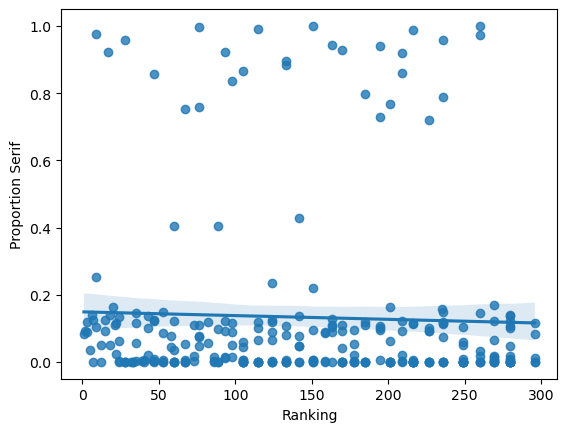

In [168]:
X = valid_data["ranking.sortRank"]
y = valid_data["Proportion Serif"].astype(float)
plot = sns.regplot(x=X, y=y)
axes = plot.set(xlabel="Ranking")

Wuh oh.... let's see the p-value of that...

In [169]:
X_np = X.to_numpy().reshape(X.shape[0], 1)
y_np = y.to_numpy().reshape(y.shape[0], 1)
f_stat, p_values = f_regression(X_np, y_np)

p_values[0]

c:\Users\Tony Zheng\.conda\envs\Scraping\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5364234507303405

implying an ~53% chance that there is no correlation whatsoever. Whelp.

## Conclusion

Don't make your college decisions based on a college's font choice.